In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

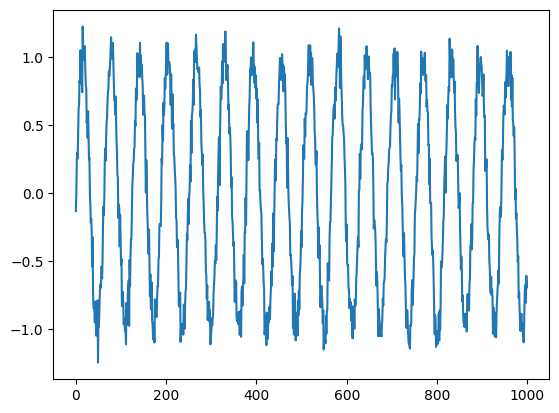

In [2]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.plot(series)
plt.show()

In [3]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990, 1)


In [4]:
### try autoregressive linear model
model = nn.Linear(T, 1)

In [5]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [6]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [7]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [8]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.4534, Test Loss: 0.2666
Epoch 10/200, Train Loss: 0.1884, Test Loss: 0.1890
Epoch 15/200, Train Loss: 0.0364, Test Loss: 0.0710
Epoch 20/200, Train Loss: 0.0359, Test Loss: 0.0204
Epoch 25/200, Train Loss: 0.0627, Test Loss: 0.0398
Epoch 30/200, Train Loss: 0.0417, Test Loss: 0.0395
Epoch 35/200, Train Loss: 0.0216, Test Loss: 0.0236
Epoch 40/200, Train Loss: 0.0179, Test Loss: 0.0158
Epoch 45/200, Train Loss: 0.0197, Test Loss: 0.0148
Epoch 50/200, Train Loss: 0.0203, Test Loss: 0.0154
Epoch 55/200, Train Loss: 0.0189, Test Loss: 0.0151
Epoch 60/200, Train Loss: 0.0176, Test Loss: 0.0147
Epoch 65/200, Train Loss: 0.0170, Test Loss: 0.0143
Epoch 70/200, Train Loss: 0.0166, Test Loss: 0.0140
Epoch 75/200, Train Loss: 0.0162, Test Loss: 0.0137
Epoch 80/200, Train Loss: 0.0160, Test Loss: 0.0135
Epoch 85/200, Train Loss: 0.0159, Test Loss: 0.0133
Epoch 90/200, Train Loss: 0.0157, Test Loss: 0.0133
Epoch 95/200, Train Loss: 0.0156, Test Loss: 0.0132
Epoch 100/200

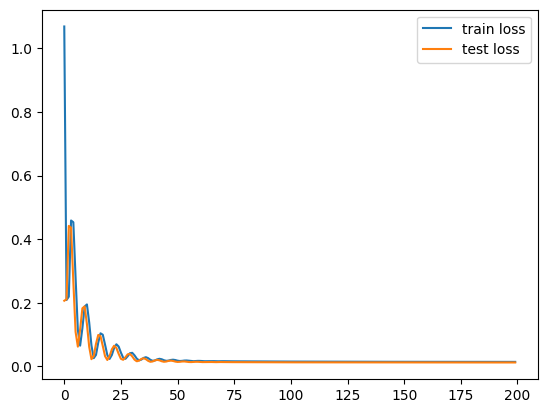

In [9]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [10]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, -1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

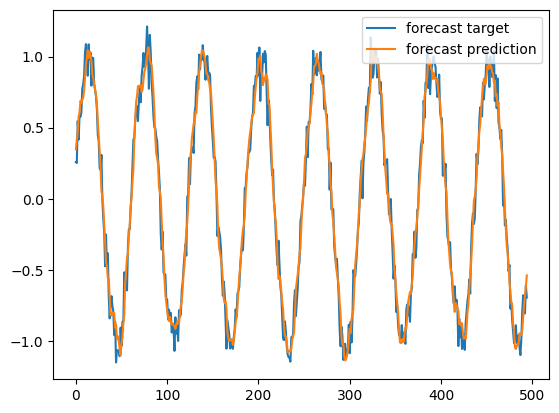

In [11]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [12]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, -1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

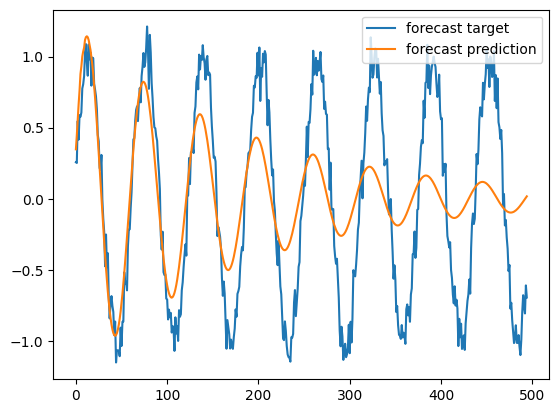

In [13]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()